# VGG-16 Model on CIFAR-10 Dataset
*Author: Gian Carlo Baldonado*

## Objective
The goal of this notebook is to apply the VGG-16 pretrained model on the CIFAR-10 dataset. 

## Resources
* **About VGG-16**
The VGG model is based on the Very Deep Convolutional Networks for Large-Scale Image Recognition paper. VGG16 is a convolution neural net architecture used for image recognition. It uses 16 layers with weights. https://arxiv.org/abs/1409.1556

* **About CIFAR-10**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. http://www.cs.toronto.edu/~kriz/cifar.html

## 1.) Import packages and notebook settings

In [68]:
# requisite imports
import torch
import tqdm 
import os
import timeit

import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random

import torch.optim as optim

import numpy as np

**Device setting**: Devices with MPS available will use MPS, cuda will use cuda, and if both are not available, `device` is set to CPU.

In [69]:
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda:0' if torch.cuda.is_available() else 'cpu'))
print(device)

mps


**Seed Setting**:
Different sources of randomness contribute to the result of a neural network model. Nevertheless, a good neural network model should not depend on the eed but the data, architecture, and hyperparameters used. We introduce a seed value for the sake of reproducibility of our results. We set the `seed_value` to `42` for the following sources of randomness:
1. within the environment
2. within Python
3. within some packages like numpy and torch
4. and anywhere else where randomness is introduced like within architectures (some dropout layers introduce randomness) 


In [70]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` and `torch` pseudo-random generator at a fixed value
np.random.seed(seed_value)
torch.manual_seed(seed_value)

**Variable setting**

In [71]:
BATCH_SIZE = 64
NUM_EPOCHS = 5
LR = 2E-5

# 2.) Load and Transform CInn.functionalAR-10 dataset

The CIFAR-10 dataset is popular enough that `torchvision.datasets` has CIFAR-10 as one of its built-in datasets. https://pytorch.org/vision/stable/datasets.html#datasets

In [72]:
# Load the CIFAR train dataset
train = torchvision.datasets.CIFAR10("data/", train=True, download=True)
test = torchvision.datasets.CIFAR10("data/", train=False, download=True) 

Files already downloaded and verified
Files already downloaded and verified


**Transform**: Transforming a dataset when loading it is an important and common practice in computer vision. It is used for the following:
* *Data augmentation*: Increase the size and diversity of dataset, which can improve model performance. For ex., flip, rotate or crop images to create new images.
* *Normalization*: Normalize the distribution of hte pixel values, making the data easier for the model to learn.
* *Preprocessing*: Prepare data for a specific model, like perhaps you need to resize the images or convert them to another format.

Note: You can skip `transform` but it is not recommended. It may lead to overfitting, poor performance, or incompatibility of the data with the model you're using.

Resource on transformation: https://pytorch.org/vision/main/transforms.html

To start, I chose *normalization* for transformation.

In [73]:
# print(train.data) #train.data is of type numpy array 
# normalize train.data by dividing the array by 255. This will normalize all of the pixel values in the array between 0 and 1. 
# 255 is the max value for a pixel in a typical image.
normalized_train = train.data / 255
mean = normalized_train.mean(axis = (0,1,2))
std = normalized_train.std(axis = (0,1,2))
print(f"train mean: {mean}, train std: {std}")

train mean: [0.49139968 0.48215841 0.44653091], train std: [0.24703223 0.24348513 0.26158784]


We will feed these `mean` and `std` to the `transforms.v2.Compose()`

In [87]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean, std)])

# reload our train and test sets with transformation
train = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 
test = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 

# size of the validation set
val_size = 10000

# size of the train set
train_size = len(train) - val_size

# split the train into a train and a validation set, in accordance to the determined train and val sizes
train, val = random_split(train, [train_size, val_size])

# load the train, test, and val to our dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


**Visualizing images**

In [88]:
def imshow(img):
    img_np = img.numpy()
    img_np = img_np / 2 + 0.5 # unnormalize image
    plt.axis('off')
    plt.imshow(np.transpose(img_np, (1,2,0)))
    plt.show
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship plane dog frog ship bird frog horse truck horse bird ship ship plane bird deer car car truck deer cat truck plane horse dog truck plane horse plane dog bird dog bird ship plane truck truck dog dog frog bird truck bird plane car truck dog deer deer plane car ship truck deer plane deer truck cat deer car cat plane dog truck


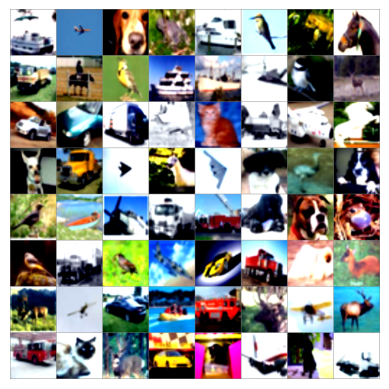

In [89]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(BATCH_SIZE)))

## 3. Define a GGV-16 Neural Network

**How models work in PyTorch**
Every custom model is inherited from the `nn.Module` class. This class provides basic functionality that helps the model to train. There are 2 main things we need to define:
* `__init__` 
* `forward` 

**Types of layers and definitions**

* `nn.Conv2d`: convolutional layers that accepts no. of input and output channels as args, along with kernel size for the filter. It accepts strides and paddings as well, if you wish to implement this.
* `nn.Batchnormd2`: batch normalization layers for the output of the convolutional layers.
* `nn.ReLU`: an activation layer applied to the outputs in the network.
* `nn.MaxPool2d`: max pooling layer to the output with the given kernel size
* `nn.DropOut`: dropout regularization layer with a given probability
* `nn.Linear`: essentially a fully connected layer
* `nn.Sequential`: not really a layer, but combines different operations part of the same step

In [90]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.relu(self.conv7(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv8(x))
        x = nn.functional.relu(self.conv9(x))
        x = nn.functional.relu(self.conv10(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv11(x))
        x = nn.functional.relu(self.conv12(x))
        x = nn.functional.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = nn.functional.relu(self.fc14(x))
        x = nn.functional.dropout(x, 0.5) #dropout was included to combat overfitting
        x = nn.functional.relu(self.fc15(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [91]:
class VGG16(nn.Module):
    # paper implementation of GGV-16
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Instantiate a model and transfer it to the device.

In [92]:
model = VGG16_NET()
model.to(device)

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

**Define a loss function and optimizer**

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## 4. Train the model

We simply have a function that takes in our data loader, the model, our optimizer, a scheduler, a loss function, epochs, and whether if we want to use scheduler or not. We keep track of train_losses, val_losses, and the times for when the model is finished.

In [102]:
def train_loop(tr_loader, vl_loader, model, optimizer, scheduler, loss_fn, epochs, use_scheduler=True):
    """
    Abstract training loop for a deep learning model.

    Parameters:
    - tr_loader: input loader for the training inputset.
    - vl_loader: input loader for the validation set.
    - model: The neural network model to train.
    - optimizer: The optimization algorithm.
    - scheduler: Learning rate scheduler.
    - loss_fn: Loss function.
    - epochs: Number of training epochs.
    - use_scheduler: Whether to use a learning rate scheduler.

    Returns:
    - Trained model.
    - List of average losses for each epoch.
    - List of times taken for each epoch.
    """
    
    print("Starting training", device)
    model.to(device)

    # collect train and val losses so we can inspect learning curve of model
    train_losses_history = []
    val_losses_history = []
    # collect train and val corrects so we can compute accuracy
    train_corrects_history = []
    val_corrects_history = []
    # collect times it takes for each epoch
    epoch_times_history = []

    tq = tqdm.tqdm(range(epochs)) # creates a tqdm progress bar that will iterate over the range of epochs, useful for tracking progress

    for e in tq: 
        train_loss = 0.0
        val_loss = 0.0
        train_corrects = 0.0
        val_corrects = 0.0
        losses = []
        start_time = timeit.default_timer()
        
        for inputs, label in tr_loader:
            inputs, label = inputs.to(device), label.to(device) # input and labels to device since model is running in device
            outputs = model(inputs) # per batch, images are put as input to the model
            loss = loss_fn(outputs, label) # calculate the loss after each batch by comparing it to actual labels
            optimizer.zero_grad() # set the initial gradient to 0
            loss.backward() # backpropagate the loss
            optimizer.step() # udpate weights and biases for every single step

            _, preds = torch.max(outputs, 1) # take the highest value of prediction
            train_loss += loss.item()
            train_corrects += torch.sum(preds == labels.data.to(device)) # calculate accuracy by taking sum of all the predictions in a batch
            losses.append(loss.to("cpu")) 

        if use_scheduler:
            scheduler.step()
        
        end_time = timeit.default_timer() # timer ends when training ends

        with torch.no_grad(): # we do not need gradients for validation
            for val_inputs, val_labels in vl_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = loss_fn(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_loss += val_loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data.to(device))
        
        train_epoch_loss = train_loss/(len(tr_loader)*BATCH_SIZE)
        train_epoch_acc = train_corrects.float()/(len(tr_loader)*BATCH_SIZE)
        train_losses_history.append(train_epoch_loss) # to visualize learning curve through epoch
        train_corrects_history.append(train_epoch_acc.cpu().numpy()) # to visualize accuracy through epoch

        val_epoch_loss = val_loss/(len(vl_loader)*BATCH_SIZE)
        val_epoch_acc = val_corrects.float()/(len(vl_loader)*BATCH_SIZE)
        val_losses_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc.cpu().numpy())
        epoch_times_history.append(end_time - start_time)

        # Create a report out of the model loss, accuracies, and times
        report = {'train_losses_history': train_losses_history,
                  'train_corrects_history': train_corrects_history,
                  'val_losses_history': val_losses_history,
                  'val_corrects_history': val_corrects_history,
                  'epoch_times_history': epoch_times_history}
        
        print('epoch:', (e+1))
        print(f'training loss: {train_epoch_loss}, training accuracy: {train_epoch_acc}')
        print(f'validation loss: {val_epoch_loss}, validation accuracy: {val_epoch_acc}')
    print("Finished training.")
    return model, report

In [103]:
train_loop(train_loader, val_loader, model, optimizer, scheduler, criterion, True)

Starting training mps


  0%|          | 0/1 [00:07<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!